# Southbank occupancy rates 

This notebook describes an approach to suggest removal of on-street car parks based on occupancy rate. 
To calculate to the total occupancy rate, the durationseconds column can be used to see how often each parking bay was used. 
It's not possible to run this over the whole data set so I have started by filtering by area = Soutbank. 

In [4]:
import missingno as msno
# to see where nulls are

In [1]:
import pandas as pd
import numpy as np
import requests
from sodapy import Socrata
import datetime as dt
# need datetime to manipulate dates

In [2]:
client = Socrata("data.melbourne.vic.gov.au", "RG1MLdEhMl8N8uP4WMDWLJ3Yz")

# Soutbank filter, with all parking instances: This is a big call so will take time to run ~2.7mil rows
results = client.get("u9sa-j86i", area='Southbank', limit=3000000)

# Convert to pandas DataFrame
sensor_df = pd.DataFrame.from_records(results)

In [5]:
# All on-street parking bays: lat, long of parking bays
results2 = client.get("wuf8-susg", limit=30000)

# Convert to pandas DataFrame
location_df = pd.DataFrame.from_records(results2)

In [ ]:
# if wanting to investigate restrictions dataset
# All parking restrictions: extended info for restrictions
# results3 = client.get("ntht-5rk7", limit=4200)

# Convert to pandas DataFrame
# restriction_df = pd.DataFrame.from_records(results3)

#### Prep sensor dataframe for analysis

In [8]:
sensor_df.shape

(2734379, 14)

In [9]:
# only keep useful columns
sensor_df = sensor_df[['arrivaltime', 'departuretime','durationseconds','streetmarker','in_violation']]

In [10]:
sensor_df.head()

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation
0,2017-07-13T20:20:05.000,2017-07-13T22:46:33.000,8788,8668E,False
1,2017-04-21T13:12:01.000,2017-04-21T15:42:32.000,9031,8340E,False
2,2017-01-13T11:52:18.000,2017-01-13T12:02:09.000,591,9427S,False
3,2017-09-16T22:15:44.000,2017-09-16T22:21:06.000,322,9939S,False
4,2017-10-31T12:28:27.000,2017-10-31T12:29:04.000,37,10051S,False


In [87]:
sensor_df.isnull().sum()

arrivaltime        0
departuretime      0
durationseconds    0
streetmarker       0
in_violation       0
dtype: int64

In [88]:
sensor_df.dtypes
# need to change to useful data types for math operations and date manipulation

arrivaltime        object
departuretime      object
durationseconds    object
streetmarker       object
in_violation       object
dtype: object

In [11]:
sensor_df['durationseconds'] = sensor_df['durationseconds'].astype(int)
# have to change duration to integer to do any aggregate calcs

In [90]:
sensor_df['durationseconds'].nunique

<bound method IndexOpsMixin.nunique of 0           8788
1           9031
2            591
3            322
4             37
           ...  
2734374     5234
2734375    12594
2734376      502
2734377     6238
2734378       32
Name: durationseconds, Length: 2734379, dtype: int32>

In [91]:
sensor_df['durationseconds'].sort_values().unique

<bound method Series.unique of 1575067       -3473
1585840       -3027
2357926       -2817
306193        -2725
1032766       -2449
             ...   
578574     28988177
1978770    28988373
791390     28998611
683535     28999478
1998067    28999905
Name: durationseconds, Length: 2734379, dtype: int32>

In [92]:
# on 2017 sensor data website, there is a note under known data issues: some durations have negative numbers due to sensors
# detecting an arrival time after a vehicle has departed. These -ve numbers can be removed.

In [14]:
sensor_df = sensor_df[(sensor_df['durationseconds'] >= 0)]
# keep everything greater than or equal to 0, remove -ve numbers

In [94]:
sensor_df.shape

(2734360, 5)

In [15]:
sensor_df['durationseconds'].sort_values().unique

<bound method Series.unique of 2508935           0
462920            0
1307032           0
2291717           0
32550             0
             ...   
578574     28988177
1978770    28988373
791390     28998611
683535     28999478
1998067    28999905
Name: durationseconds, Length: 2734360, dtype: int32>

#### Group by and calculate occupancy rate

In [16]:
southbank_groupby = sensor_df.groupby(['streetmarker']).agg(max_duration=('durationseconds', max),\
    min_duration=('durationseconds', min), total_duration=('durationseconds', sum), \
    annual_occupancy=('durationseconds', lambda x: ((sum(x))/31536000)))
# this groupby gives the output below
# the occupancy rate calculation is the sum of all the durations for each parking instance in 2017 / total seconds in a year
# number seconds in a year = 31536000

In [17]:
southbank_groupby.sort_values(by = 'annual_occupancy', ascending = False).head(10)

,max_duration,min_duration,total_duration,annual_occupancy
streetmarker,,,,
9138N,21145312,0,3.227753e+10,1023.513732
8000E,28999905,0,5.877521e+09,186.374961
8015W,4308718,0,3.342147e+07,1.059788
9824N,39600,0,3.141170e+07,0.996058
9830N,39600,6,3.136737e+07,0.994653
10034N,62044,0,3.133519e+07,0.993632
9826N,37788,3,3.132758e+07,0.993391
8346E,86136,0,3.132433e+07,0.993288
9956N,39600,4,3.131894e+07,0.993117


#### Investigate why top 3 results are off the scale

In [98]:
check_mask = sensor_df['streetmarker'] == '9138N'

In [99]:
check_mask_9138N = sensor_df[check_mask]

In [100]:
check_mask_9138N.shape[0]

2483

In [101]:
check_mask_9138N.sort_values(by = 'durationseconds', ascending = False).head(10)

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation
2685893,2017-03-24T13:47:08.000,2017-11-24T07:29:00.000,21145312,9138N,False
516096,2017-03-24T15:25:01.000,2017-11-24T08:03:42.000,21141521,9138N,False
1978548,2017-03-24T15:19:58.000,2017-11-24T07:31:43.000,21139905,9138N,False
647763,2017-03-24T17:03:01.000,2017-11-24T08:28:01.000,21137100,9138N,False
997658,2017-03-24T16:53:43.000,2017-11-24T08:09:54.000,21136571,9138N,False
766633,2017-03-24T18:30:25.000,2017-11-24T09:20:01.000,21134976,9138N,False
1745320,2017-03-24T18:18:51.000,2017-11-24T08:51:52.000,21133981,9138N,False
135,2017-03-24T18:16:25.000,2017-11-24T08:29:28.000,21132783,9138N,False
2107529,2017-03-24T23:08:41.000,2017-11-24T12:07:17.000,21128316,9138N,False
939162,2017-03-24T11:10:31.000,2017-11-24T00:00:00.000,21127769,9138N,False


In [102]:
21145312/31536000
# multiple very high duration parking instances recorded at the same time. Can remove this streetmarker from the analysis
# due to likely sensor error

0.6705134449518011

In [103]:
check_mask1 = sensor_df['streetmarker'] == '8000E'

In [104]:
check_mask_8000E = sensor_df[check_mask1]

In [105]:
check_mask_8000E.shape[0]

6159

In [106]:
check_mask_8000E.sort_values(by = 'durationseconds', ascending = False).head(10)

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation
1998067,2017-01-29T18:39:57.000,2017-12-31T10:11:42.000,28999905,8000E,False
683535,2017-01-29T18:21:07.000,2017-12-31T09:45:45.000,28999478,8000E,False
791390,2017-01-29T18:38:37.000,2017-12-31T09:48:48.000,28998611,8000E,False
1978770,2017-01-30T09:49:15.000,2017-12-31T22:08:48.000,28988373,8000E,False
578574,2017-01-30T09:48:10.000,2017-12-31T22:04:27.000,28988177,8000E,False
401334,2017-01-30T10:03:35.000,2017-12-31T22:10:10.000,28987595,8000E,False
700972,2017-01-30T00:00:00.000,2017-12-31T11:33:43.000,28985623,8000E,False
287983,2017-01-30T09:45:20.000,2017-12-31T20:01:59.000,28980999,8000E,False
1951331,2017-01-30T05:34:54.000,2017-12-31T11:46:22.000,28966288,8000E,False
53698,2017-01-30T05:32:24.000,2017-12-31T11:43:50.000,28966286,8000E,False


In [107]:
check_mask2 = sensor_df['streetmarker'] == '8015W'

In [108]:
check_mask_8015W = sensor_df[check_mask2]

In [109]:
check_mask_8015W.shape[0]

4458

In [110]:
check_mask_8015W.sort_values(by = 'durationseconds', ascending = False).head(10)

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation
1685292,2017-06-02T19:52:20.000,2017-07-22T16:44:18.000,4308718,8015W,False
1294461,2017-07-16T00:00:00.000,2017-07-17T00:00:00.000,86400,8015W,False
2252222,2017-12-10T00:00:00.000,2017-12-11T00:00:00.000,86400,8015W,False
2248135,2017-11-25T00:00:00.000,2017-11-26T00:00:00.000,86400,8015W,False
60922,2017-04-08T00:00:00.000,2017-04-09T00:00:00.000,86400,8015W,False
394179,2017-02-05T00:00:00.000,2017-02-06T00:00:00.000,86400,8015W,False
2582355,2017-08-27T00:00:00.000,2017-08-28T00:00:00.000,86400,8015W,False
1669210,2017-11-26T00:00:00.000,2017-11-27T00:00:00.000,86400,8015W,False
1359344,2017-04-09T00:00:00.000,2017-04-10T00:00:00.000,86400,8015W,False
1529849,2017-12-23T00:00:00.000,2017-12-24T00:00:00.000,86400,8015W,False


In [111]:
4308718/31536000
# this first entry is unusually high compared to other max values. It's likely this is contributing to 
# the occupancy rate for the year being over 100%

0.1366285514967022

#### remove three streetmarkers as outliers 

In [127]:
sensor_df.shape

(2734360, 5)

In [18]:
# Get indexes where name column has value 
indexNames = sensor_df[sensor_df['streetmarker'] == '9138N'].index
 
# Delete these row indexes from dataFrame
sensor_df.drop(indexNames , inplace=True)

In [19]:
# Get indexes where name column has value 
indexNames = sensor_df[sensor_df['streetmarker'] == '8000E'].index
 
# Delete these row indexes from dataFrame
sensor_df.drop(indexNames , inplace=True)

In [20]:
# Get indexes where name column has value 
indexNames = sensor_df[sensor_df['streetmarker'] == '8015W'].index
 
# Delete these row indexes from dataFrame
sensor_df.drop(indexNames , inplace=True)

In [21]:
sensor_df.shape

(2721260, 5)

In [134]:
# check if rows have been removed properly
sum_rows_to_remove = check_mask_9138N.shape[0] + check_mask_8000E.shape[0] + check_mask_8015W.shape[0]

In [136]:
sum_rows_to_remove

13100

In [138]:
2734360 - sum_rows_to_remove
# old df row - sum of rows of streetmarkers removed --> It equals new dataframe so we know correct rows have been removed

2721260

In [139]:
sensor_df.shape

(2721260, 5)

In [22]:
#rerun groupby on cleaned sensor_df
southbank_groupby = sensor_df.groupby(['streetmarker']).agg(max_duration=('durationseconds', max),\
    min_duration=('durationseconds', min), total_duration=('durationseconds', sum), \
    annual_occupancy=('durationseconds', lambda x: ((sum(x))/31536000)))

In [23]:
southbank_groupby.sort_values(by = 'annual_occupancy', ascending = False).head(10)

,max_duration,min_duration,total_duration,annual_occupancy
streetmarker,,,,
9824N,39600,0,31411698,0.996058
9830N,39600,6,31367373,0.994653
10034N,62044,0,31335189,0.993632
9826N,37788,3,31327583,0.993391
8346E,86136,0,31324329,0.993288
9956N,39600,4,31318936,0.993117
9828N,39600,2,31307388,0.992751
9834N,36595,4,31253477,0.991041
8354E,86400,0,31245115,0.990776


<AxesSubplot:>

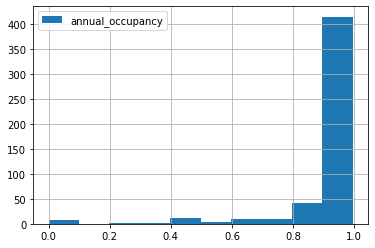

In [31]:
southbank_groupby['annual_occupancy'].hist(legend = True )
# this histogram can help with determining threshhold limits

In [232]:
# further analysis could investigate low occupancy bays as well to see if they are outliers

In [25]:
southbank_groupby = southbank_groupby.reset_index()

In [26]:
southbank_groupby.sort_values(by = 'annual_occupancy').head(10)
# can make arguement: bays with occupancy rate of less than 'x' amount can be suggested for removal (not being utilised)

,streetmarker,max_duration,min_duration,total_duration,annual_occupancy
215,9086N,496,496,496,0.000016
285,9277S,2604,2604,2604,0.000083
286,9279S,10011,253,12878,0.000408
199,8881W,46800,5,1087311,0.034478
160,8656E,33179,4,1091567,0.034613
193,8850E,55516,10,1099532,0.034866
251,9236N,86400,50,1103400,0.034989
192,8848E,86400,5,7397260,0.234566
189,8838E,86400,0,12545222,0.397806
191,8846E,86400,0,13214422,0.419027


In [27]:
stats = southbank_groupby.describe()

In [33]:
stats[['annual_occupancy']]
# 499 marker id's
# mean occupancy accross marker id's is 0.90
# could potentiall use interquartile range as a determiner for threshold limits. Histogram also helps with this
# leave to see map in Tableau and make judgement categories of occupancy rates.

,annual_occupancy
count,499.000000
mean,0.909272
std,0.150238
min,0.000016
25%,0.915477
50%,0.955710
75%,0.978430
max,0.996058


#### merge with location_df to visualize the map of occupancy rate

In [147]:
location_df.head()

,the_geom,marker_id,bay_id,last_edit,rd_seg_id,rd_seg_dsc,meter_id
0,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",20268E,17200,20201223122254,22277,St Leonards Court from Anderson Street,NaN
1,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",NaN,12554,20201208141056,20524,Lygon Street between Queensberry Street and Ar...,NaN
2,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",NaN,5246,20201223122247,21015,Queensberry Street between Curzon Street and A...,NaN
3,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",NaN,21476,20201208141949,22106,Wells Street between Grant Street and Miles St...,NaN
4,"{'type': 'MultiPolygon', 'coordinates': [[[[14...",NaN,11451,20201208140949,20482,Swanston Street between Victoria Street and Qu...,NaN


<AxesSubplot:>

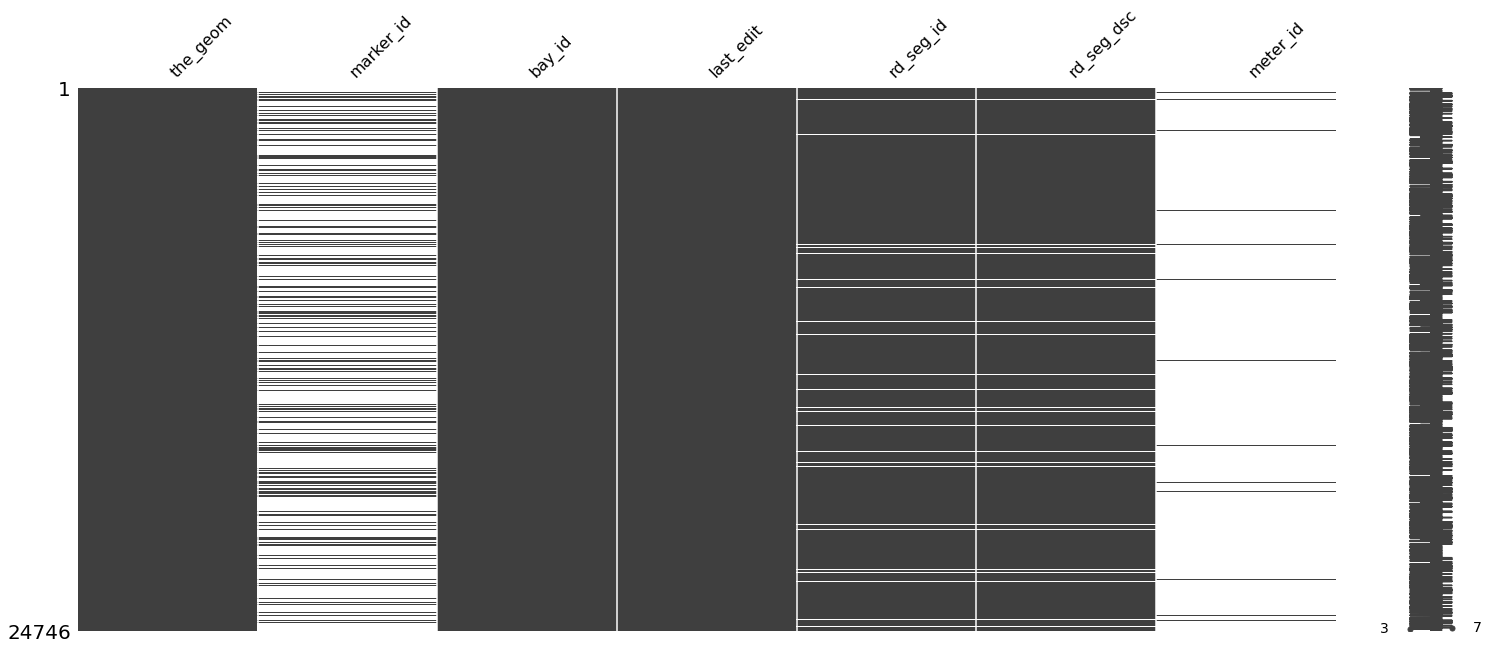

In [6]:
msno.matrix(location_df)
# remove missing marker_ids

In [148]:
location_df = location_df.dropna(subset = ['marker_id'])

In [149]:
location_df.shape

(6015, 7)

In [150]:
location_df = location_df.drop_duplicates(subset = 'marker_id')

In [151]:
location_df.marker_id.value_counts().sort_values(ascending = False)

8442E     1
8781W     1
9515S     1
13608E    1
8451W     1
         ..
9427S     1
15031W    1
103W      1
5472E     1
20388E    1
Name: marker_id, Length: 6001, dtype: int64

In [152]:
location_df.shape

(6001, 7)

In [153]:
location_df['coordinates'] = location_df.the_geom.apply(lambda x: x['coordinates'][0][0][0])

In [154]:
location_df[['long','lat']] = pd.DataFrame(location_df['coordinates'].tolist(), index = location_df.index)

In [155]:
location_df = location_df[['marker_id','long','lat']]

In [156]:
location_df.rename(columns = {'marker_id':'streetmarker'}, inplace = True)

In [157]:
location_df.columns

Index(['streetmarker', 'long', 'lat'], dtype='object')

In [158]:
location_df.head()
# this is the cleaned location dataset ready to merge

,streetmarker,long,lat
0,20268E,144.985531,-37.829758
9,4902E,144.958095,-37.808002
12,8481W,144.966757,-37.825113
13,20308E,144.985862,-37.832815
19,3914N,144.955170,-37.812031


In [159]:
location_df.shape

(6001, 3)

In [160]:
southbank_groupby.shape

(499, 4)

In [172]:
southbank_groupby.columns

Index(['streetmarker', 'max_duration', 'min_duration', 'total_duration',
       'annual_occupancy'],
      dtype='object')

In [173]:
southbank_occupancy = pd.merge(southbank_groupby, location_df, on="streetmarker")

In [174]:
southbank_occupancy.shape

(435, 7)

In [175]:
southbank_occupancy.head()

,streetmarker,max_duration,min_duration,total_duration,annual_occupancy,long,lat
0,10041S,55800,0,25709355,0.815238,144.965739,-37.823369
1,10043S,55800,0,25377488,0.804715,144.965666,-37.823379
2,10049S,72833,0,30539049,0.968387,144.963199,-37.822029
3,10051S,85408,0,30569164,0.969342,144.963199,-37.822029
4,10053S,68900,0,30398254,0.963922,144.963153,-37.821985


In [163]:
def check_if_match(df_1, df_2, col_name_df1, col_name_df2):
    unique_to_df_1 = [i for i in df_1[col_name_df1].unique() if i not in df_2[col_name_df2].unique()]
    unique_to_df_2 = [i for i in df_2[col_name_df2].unique() if i not in df_1[col_name_df1].unique()]
    common_to_df_1_and_df_2 = [i for i in df_2[col_name_df2].unique() if i in df_1[col_name_df1].unique()]
    print('values unique to df_1', str(len(unique_to_df_1)))
    print('values unique to df_2', str(len(unique_to_df_2)))
    print('values common to df_1 and df_2', str(len(common_to_df_1_and_df_2)))
    return unique_to_df_1, unique_to_df_2, common_to_df_1_and_df_2

In [176]:
result_unique_df_1, result_unique_df_2, result_common_df_1_df_2 = check_if_match(df_1 = southbank_groupby, \
                df_2 = location_df, col_name_df1 = 'streetmarker', col_name_df2 = 'streetmarker')

values unique to df_1 64
values unique to df_2 5566
values common to df_1 and df_2 435


In [179]:
southbank_groupby.shape[0] - southbank_occupancy.shape[0]
# this number matches unique to df1 so merge is good (with 64 streetmarkers removed due to no matching value)

64

<AxesSubplot:>

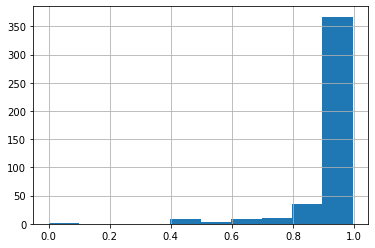

In [233]:
southbank_occupancy['annual_occupancy'].hist()

In [180]:
southbank_occupancy.to_csv('southbankoccupancy.csv')
# majority of parks are actually more than 90% (higher than I expected)
# can use this histogram to justify categories for filtering or for creating a threshold for removal suggestion

#### Playing with Southbank data in python to understand all parking instances and violation trends 

In [34]:
sensor_df['arrivaltime'] = pd.to_datetime(sensor_df['arrivaltime'])

In [35]:
sensor_df.dtypes

arrivaltime        datetime64[ns]
departuretime              object
durationseconds             int32
streetmarker               object
in_violation               object
dtype: object

In [36]:
sensor_df['year'] = pd.DatetimeIndex(sensor_df['arrivaltime']).year
# add new column with year split out

In [37]:
sensor_df['month'] = pd.DatetimeIndex(sensor_df['arrivaltime']).month

In [38]:
sensor_df['day'] = pd.DatetimeIndex(sensor_df['arrivaltime']).day

In [39]:
sensor_df['dayname'] = sensor_df.arrivaltime.dt.day_name()
# get day names of the week
# nice to have name, but doesn't plot well so use day_number

In [40]:
sensor_df['day_number'] = sensor_df['arrivaltime'].dt.dayofweek
# this gives number 0-6 with Monday being 0, Sunday 6

In [41]:
sensor_df['hour_of_day'] = sensor_df['arrivaltime'].dt.hour

In [42]:
sensor_df.head(2)

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation,year,month,day,dayname,day_number,hour_of_day
0,2017-07-13 20:20:05,2017-07-13T22:46:33.000,8788,8668E,False,2017,7,13,Thursday,3,20
1,2017-04-21 13:12:01,2017-04-21T15:42:32.000,9031,8340E,False,2017,4,21,Friday,4,13


In [ ]:
# dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
# sensor_df['weekday'] = sensor_df['arrivaltime'].dt.dayofweek.map(dayOfWeek)
# this does same as dt.day_name() above

In [ ]:
sensor_df.groupby(by=['month']).count()

In [190]:
sb_month = sensor_df.groupby(by=['month']).count()

<AxesSubplot:title={'center':'total parking instances by month'}, xlabel='month', ylabel='count of all parking instances'>

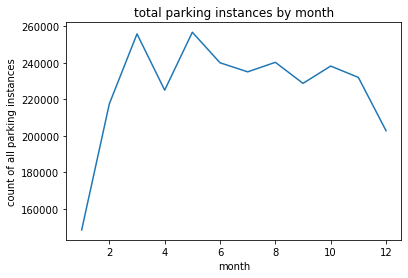

In [197]:
sb_month['arrivaltime'].plot(ylabel = 'count of all parking instances', title = 'total parking instances by month')
# all parking instances in Southbank over 2017
# trend showing drop-off over 

In [193]:
sb_month_viol = sensor_df[sensor_df['in_violation'] == 'True'].groupby(by=['month']).count()

<AxesSubplot:title={'center':'violations by month'}, xlabel='month', ylabel='count of all violations'>

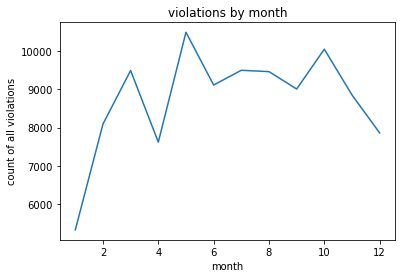

In [199]:
sb_month_viol['arrivaltime'].plot(ylabel = 'count of all violations', title = 'violations by month')
# roughly same trend shown by violations in Southbank over the year
# this plot is same as Tableau plot in Southbank monthly violations 

In [200]:
sb_day = sensor_df.groupby(by=['day_number']).count()

<AxesSubplot:title={'center':'total instances by day'}, xlabel='day_number', ylabel='count of all parking instances'>

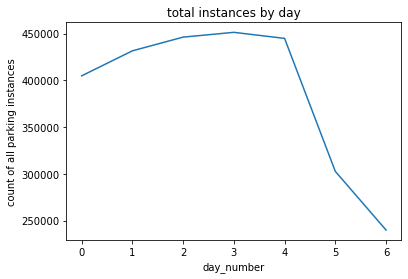

In [229]:
sb_day['arrivaltime'].plot(ylabel = 'count of all parking instances', title = 'total instances by day')
# 0 is Monday, 6 is Sunday, so trend that parking instances slightly incerase from Monday to Friday, then drop off 
# over the weekend

In [202]:
sb_day_viol = sensor_df[sensor_df['in_violation'] == 'True'].groupby(by=['day_number']).count()

<AxesSubplot:title={'center':'violations by day'}, xlabel='day_number', ylabel='count of all violations'>

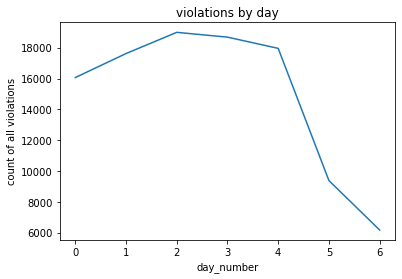

In [203]:
sb_day_viol['arrivaltime'].plot(ylabel = 'count of all violations', title = 'violations by day')
# similar trend with violations

In [223]:
sb_day_col = sb_day[['arrivaltime']]

In [225]:
sb_day_col.rename(columns = {'arrivaltime':'count_violations'}, inplace = True)
# if you want to change name of column  in output

C:\Users\tjalb\anaconda3\lib\site-packages\pandas\core\frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [226]:
sb_day_col

,count_violations
day_number,
0,404804
1,431558
2,446228
3,451338
4,444866
5,302600
6,239866


In [204]:
sb_day_viol

,arrivaltime,departuretime,durationseconds,streetmarker,in_violation,year,month,day,dayname
day_number,,,,,,,,,
0,16062,16062,16062,16062,16062,16062,16062,16062,16062
1,17620,17620,17620,17620,17620,17620,17620,17620,17620
2,18998,18998,18998,18998,18998,18998,18998,18998,18998
3,18686,18686,18686,18686,18686,18686,18686,18686,18686
4,17957,17957,17957,17957,17957,17957,17957,17957,17957
5,9374,9374,9374,9374,9374,9374,9374,9374,9374
6,6166,6166,6166,6166,6166,6166,6166,6166,6166


In [221]:
calc_day = (sb_day_viol/sb_day) * 100
# % of violations per day

<AxesSubplot:title={'center':'% of violations for all parking instances by day'}, xlabel='day_number', ylabel='% of violations'>

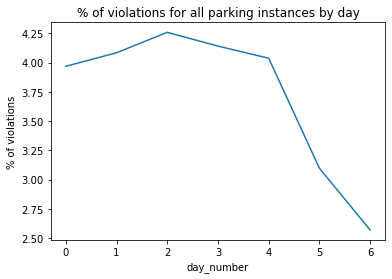

In [228]:
calc_day['arrivaltime'].plot(ylabel = '% of violations', title = '% of violations for all parking instances by day')
#slightly less % of violation over weekend: makes sense if less restrictions over weekend
#again 0 = Monday to 6 = Sunday

In [236]:
sb_hour = sensor_df.groupby(by=['hour_of_day']).count()

<AxesSubplot:title={'center':'total instances by hour'}, xlabel='hour_of_day', ylabel='count of all parking instances'>

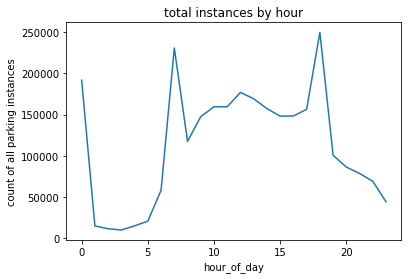

In [237]:
sb_hour['arrivaltime'].plot(ylabel = 'count of all parking instances', title = 'total instances by hour')
# hourly trend peaks around 7-8am and 5-6pm

In [43]:
sb_hour_viol = sensor_df[sensor_df['in_violation'] == 'True'].groupby(by=['hour_of_day']).count()

<AxesSubplot:title={'center':'violations by hour'}, xlabel='hour_of_day', ylabel='count of all violations'>

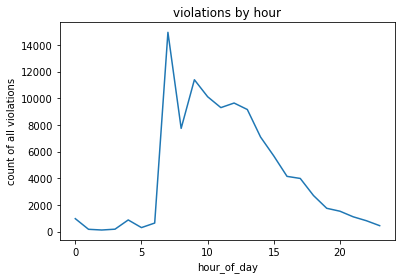

In [44]:
sb_hour_viol['arrivaltime'].plot(ylabel = 'count of all violations', title = 'violations by hour')
# similar trend with violations
# violations appear to be more in mornings and lessen over the day